# Load data

In [70]:
import pandas as pd
import numpy as np
import xarray as xr
import os
import matplotlib
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf


mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [71]:
import pickle 

def pickle_performance(model, name_str, step_window, multi_step_prediction_bool):
  assert type(name_str) is str
  assert type(multi_step_prediction_bool) is bool

  PATH = '/content/drive/My Drive/aivcc_cornvolution/performance'
  if not multi_step_prediction_bool:
    filename = 'single_step_performance'
  else:
    filename = 'multi_step_performance'
  
  with open(os.path.join(PATH, filename), 'rb') as file:
    val_performance, performance = pickle.load(file)

  val_performance[name] = model.evaluate(step_window.val)
  performance[name] = model.evaluate(step_window.test, verbose=0)

  with open(os.path.join(PATH, filename), 'wb') as file:
    pickle.dump((val_performance, performance), file)


In [72]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
os.chdir("/content/drive/My Drive")

Mounted at /content/drive


In [73]:
# Load data
input_path = '/content/drive/My Drive/aivcc_cornvolution/data'
gdhy_df = pd.read_pickle(os.path.join(input_path, 'Preprocessed', 'gdhy')).sort_index()

# Clean
gdhy_df.drop(columns=['maize_major', 'maize_second', 'rice_major', 'rice_second','wheat_spring', 'wheat_winter'], inplace=True)
gdhy_df.dropna(how='all', inplace=True)
gdhy_df.fillna(0, inplace=True)
gdhy_df.sort_index(level='year')

# Set to default dataset (makes code reusable)
df = gdhy_df

In [74]:
len(df) #Should be 756k

756309

In [75]:
gdhy_df.describe()

,maize,rice,soybean,wheat
count,756309.000000,756309.000000,756309.000000,756309.000000
mean,2.524980,1.849791,0.596513,2.016062
std,3.524051,3.128357,1.118580,2.993222
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,1.115591,0.000000,0.000000,0.487745
75%,3.524138,2.723023,0.772161,3.108415
max,31.281275,25.617229,13.383948,19.298248


## Visualize the world map

In [76]:
def get_world_map_as_array(df, year, attribute, resample_factor=None):
  # Only works with full dataframe
  world_map = gdhy_df.loc[:,:, pd.Period(year)][attribute]
  world_array = world_map.fillna(0).to_numpy().reshape((360, 720))

  if resample_factor is not None:
    world_array = zoom(world_array, resample_factor, order=1)

  return world_array

In [77]:
#plt.imshow(get_world_map_as_array(gdhy_df, 2015, 'soybean', 5), cmap='coolwarm', vmax=25, origin='lower')

# Preprocess the data
#todo location as sin and cos

Split the data by time. NO SHUFFELING

In [78]:
def add_lon_and_lat_as_sphere(df):
  lat = np.radians(df.index.get_level_values('lat'))
  lon = np.radians(df.index.get_level_values('lon') -180)

  df['x'] = np.cos(lat) * np.cos(lon)
  df['y'] = np.cos(lat) * np.sin(lon)
  df['z'] = np.sin(lat)

  return df

In [79]:
# Add years
years = df.index.get_level_values('year')
years = years.to_series()
years = years.apply(lambda x: x.year)

df['year_norm'] = years.values

# Add sperical data
df = add_lon_and_lat_as_sphere(df)

In [80]:
# split: train 70%, validation 20%, test 10%

column_indices = {name: i for i, name in enumerate(df.columns)}


n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [81]:
# Normalize all data by training data
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [82]:
train_df

maize      rice   soybean  ...         x         y         z
lat    lon    year                                ...                              
-54.25 291.25 1982 -0.727788 -0.691104 -0.534101  ...  0.331515  0.865350 -2.399490
              1983 -0.727788 -0.691104 -0.534101  ...  0.331515  0.865350 -2.399490
              1984 -0.727788 -0.691104 -0.534101  ...  0.331515  0.865350 -2.399490
              1985 -0.727788 -0.691104 -0.534101  ...  0.331515  0.865350 -2.399490
              1986 -0.727788 -0.691104 -0.534101  ...  0.331515  0.865350 -2.399490
...                      ...       ...       ...  ...       ...       ...       ...
 37.25 30.75  1999  0.152540 -0.691104 -0.534101  ... -0.631559 -0.501121  1.550429
              2000  0.141258 -0.691104 -0.534101  ... -0.631559 -0.501121  1.550429
              2001  0.074347 -0.691104 -0.534101  ... -0.631559 -0.501121  1.550429
              2002  0.084166 -0.691104 -0.534101  ... -0.631559 -0.501121  1.550429
              2003  0.303534 -0.691104 -0.534101  ... -0.631559 -0.501121  1.550429

[529416 rows x 8 columns]

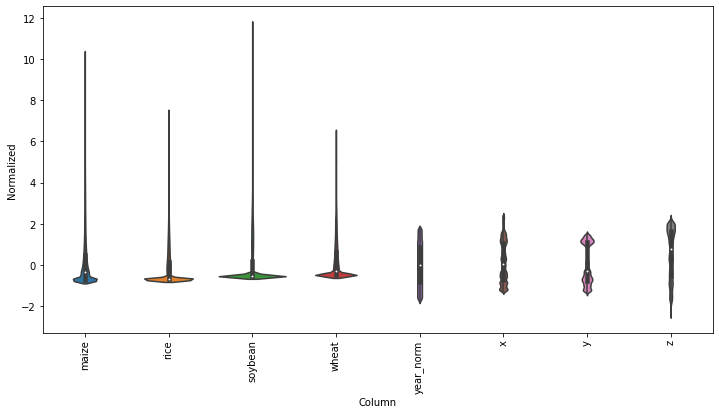

In [83]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## Data windowing

In [102]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
  
  def split_window(self, features):
    #todo
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels
  
  def make_dataset(self, data, batch_size=32):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=batch_size,)

    ds = ds.map(self.split_window)

    return ds
  
  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result

  def plot(self, model=None, plot_col, max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(3, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index],
              label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, labels[n, :, label_col_index],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)

      if n == 0:
        plt.legend()

    plt.xlabel('Time [h]')


  

SyntaxError: ignored

# SingleStep Prediction

In [85]:
label_columns = ['maize', 'rice', 'soybean', 'wheat']

In [100]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1, label_columns=label_columns)
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['maize', 'rice', 'soybean', 'wheat']

### Sample only same location

In [87]:
test_step_window = WindowGenerator(input_width=10, label_width=10, shift=5)
input, _ = next(iter(test_step_window.train))

for i in range(32):
  #todo change 4 and 5
  lat = input[i, 0, -1]
  for j in range(1, 10):
    if input[i, j, -1] != lat:
      print("error")

test_step_window

Total window size: 15
Input indices: [0 1 2 3 4 5 6 7 8 9]
Label indices: [ 5  6  7  8  9 10 11 12 13 14]
Label column name(s): None

In [88]:
test_step_window.train.batch

<bound method DatasetV2.batch of <MapDataset shapes: ((None, 10, 8), (None, 10, 8)), types: (tf.float32, tf.float32)>>

## Baseline

In [89]:
class Baseline(tf.keras.Model):
  def __init__(self, target_index=None):
    super().__init__()
    self.label_index = target_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [90]:
column_indices

{'maize': 0,
 'rice': 1,
 'soybean': 2,
 'wheat': 3,
 'x': 5,
 'y': 6,
 'year_norm': 4,
 'z': 7}

In [91]:
input, label = next(iter(single_step_window.train))
input.shape

TensorShape([32, 1, 8])

In [92]:
label.shape

TensorShape([32, 1, 4])

In [93]:
"""
baseline = Baseline(target_index=[0,1,2,3])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])


val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)
"""

val_performance = {}
performance = {}

## LinearModel

In [94]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=len(label_columns))
])

In [95]:
len(label_columns)

4

In [96]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [97]:
history = compile_and_fit(linear, single_step_window, 2)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
16545/16545 [==============================] - 73s 4ms/step - loss: 0.4599 - mean_absolute_error: 0.3277 - val_loss: 0.1312 - val_mean_absolute_error: 0.1857
Epoch 2/20
16545/16545 [==============================] - 76s 5ms/step - loss: 0.1021 - mean_absolute_error: 0.1307 - val_loss: 0.1310 - val_mean_absolute_error: 0.1860
Epoch 3/20
16545/16545 [==============================] - 73s 4ms/step - loss: 0.1021 - mean_absolute_error: 0.1307 - val_loss: 0.1310 - val_mean_absolute_error: 0.1860
Epoch 4/20
16545/16545 [==============================] - 75s 5ms/step - loss: 0.1021 - mean_absolute_error: 0.1307 - val_loss: 0.1311 - val_mean_absolute_error: 0.1853
Epoch 5/20
4727/4727 [==============================] - 17s 4ms/step - loss: 0.1311 - mean_absolute_error: 0.1860


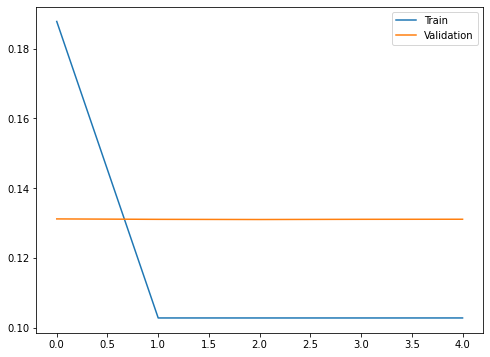

In [98]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Validation'])
plt.show()

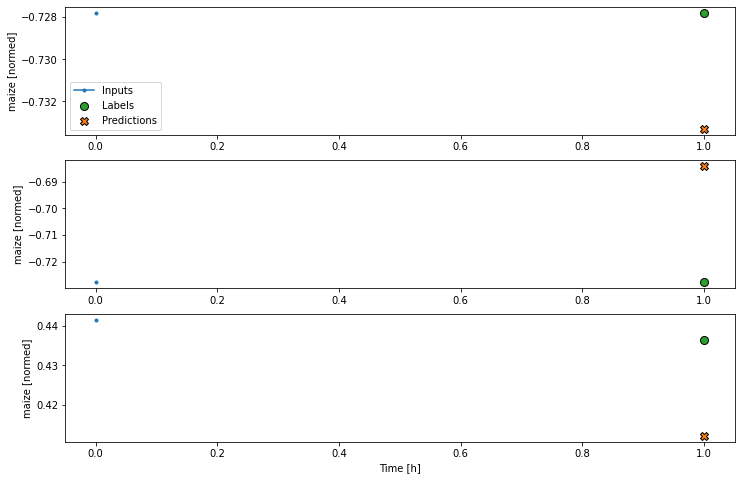

In [104]:
single_step_window.plot(linear, label_columns[0])

## CNN

In [105]:
CONV_WIDTH = 8
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=label_columns)

conv_window

Total window size: 9
Input indices: [0 1 2 3 4 5 6 7]
Label indices: [8]
Label column name(s): ['maize', 'rice', 'soybean', 'wheat']

In [106]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=8,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=8, activation='relu'),
    tf.keras.layers.Dense(units=len(label_columns)),
])

In [107]:
history = compile_and_fit(conv_model, conv_window)

val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

Epoch 1/20
16544/16544 [==============================] - 84s 5ms/step - loss: 0.1465 - mean_absolute_error: 0.1857 - val_loss: 0.1092 - val_mean_absolute_error: 0.1688
Epoch 2/20
16544/16544 [==============================] - 85s 5ms/step - loss: 0.0786 - mean_absolute_error: 0.1227 - val_loss: 0.1091 - val_mean_absolute_error: 0.1673
Epoch 3/20
16544/16544 [==============================] - 82s 5ms/step - loss: 0.0777 - mean_absolute_error: 0.1221 - val_loss: 0.1087 - val_mean_absolute_error: 0.1669
Epoch 4/20
16544/16544 [==============================] - 83s 5ms/step - loss: 0.0767 - mean_absolute_error: 0.1211 - val_loss: 0.1055 - val_mean_absolute_error: 0.1645
Epoch 5/20
16544/16544 [==============================] - 82s 5ms/step - loss: 0.0753 - mean_absolute_error: 0.1203 - val_loss: 0.1041 - val_mean_absolute_error: 0.1631
Epoch 6/20
16544/16544 [==============================] - 83s 5ms/step - loss: 0.0740 - mean_absolute_error: 0.1198 - val_loss: 0.1002 - val_mean_absolute_

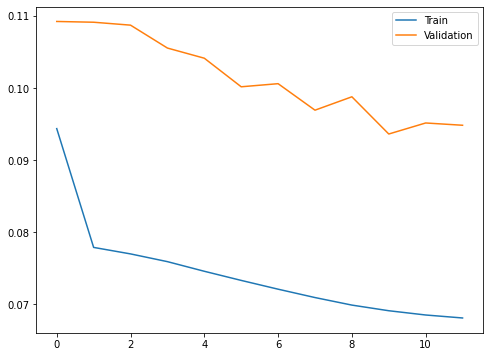

In [108]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Validation'])
plt.show()

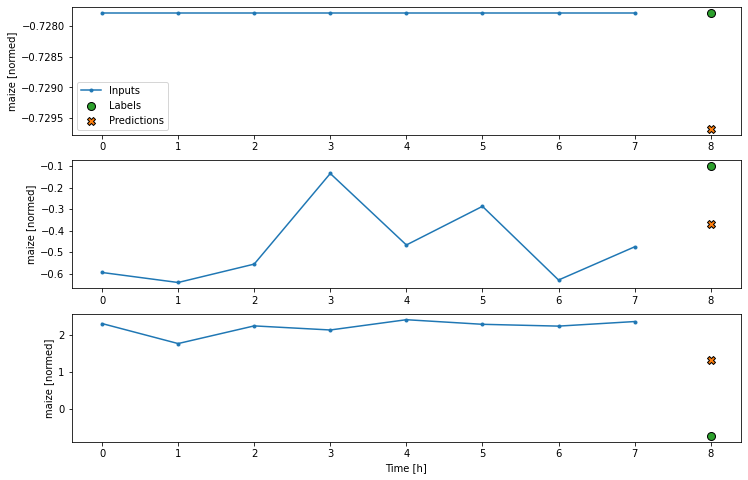

In [111]:
# maize
conv_window.plot(conv_model, label_columns[0])

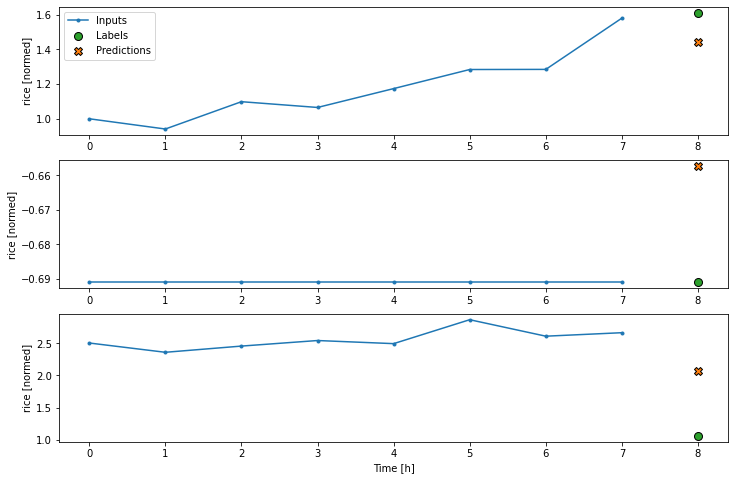

In [113]:
# rice 
conv_window.plot(conv_model, label_columns[1])